# ITI110 Model Optimsation with Optuna - hourly / loss: Poisson (N-BEATS) (Mag)
#### Loss function: Poisson

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

# Test on hourly dataset

### Load data and extract columns required for training

In [3]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

user_folder = '/content/drive/My Drive/Data/ITI110/'

Mounted at /content/drive


In [4]:
df = pd.read_csv(user_folder + '2.2 merged_aggregated_hourly_without_block_id.csv')
df['ds'] = pd.to_datetime(df["tstp"], format='%Y-%m-%d %H:%M:%S')
# Extract columns required for training and convert column names to NBEATS config
df_nbeats = df[['ds', 'avg_energy_per_lclid', 'holiday', 'temperature', 'humidity', 'windSpeed']]
df_nbeats.insert(1, 'unique_id', 1)
df_nbeats['unique_id'] = 1
df_nbeats.rename(columns={'avg_energy_per_lclid':'y'}, inplace= True)
df_nbeats.head()


,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [5]:
df_nbeats.dtypes

ds             datetime64[ns]
unique_id               int64
y                     float64
holiday               float64
temperature           float64
humidity              float64
windSpeed             float64
dtype: object

In [6]:
df_nbeats['y'] = df_nbeats['y'].astype('float')
df_nbeats['holiday'] = df_nbeats['holiday'].astype('float')
df_nbeats['temperature'] = df_nbeats['temperature'].astype('float')
df_nbeats['humidity'] = df_nbeats['humidity'].astype('float')
df_nbeats['windSpeed'] = df_nbeats['windSpeed'].astype('float')


In [ ]:
# # Extract columns required for training and convert column names to NBEATS config
# df_nbeats = df[['ds', 'avg_energy_per_lclid', 'holiday', 'temperature', 'humidity', 'windSpeed']]
# df_nbeats.insert(1, 'unique_id', 1)
# df_nbeats['unique_id'] = 1
# df_nbeats.rename(columns={'avg_energy_per_lclid':'y'}, inplace= True)
# df_nbeats.head()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


### Check on missing data and compare different methods of imputation

In [9]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
15758,2013-09-09 23:00:00,1,0.294621,0.0,NaN,NaN,NaN
15759,2013-09-10 00:00:00,1,0.251980,0.0,NaN,NaN,NaN


In [7]:
# Apply interpolation on dataset
df_nbeats = df_nbeats.interpolate("ffill")
df_nbeats.isna().any()

ds             False
unique_id      False
y              False
holiday        False
temperature    False
humidity       False
windSpeed      False
dtype: bool

In [11]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed


### Split data into train and test datasets

In [ ]:
# reserve 7 days *24 hours data for test
# test = 168 data points

In [8]:
# Test_value: 0.8

test = df_nbeats[len(df_nbeats) - 168:]  # start row: 19696

train_rows = int(0.8*(len(df_nbeats)-168))

train = df_nbeats[:train_rows]
val = df_nbeats[train_rows:-168]

# Check rows
print("dataset size: ", len(df_nbeats))
print("train length: ", len(train))
print("last row of train: ", train.index[-1])
print("val length: ", len(val))
print("first row of val: ", val.index[0])
print("last row of val: ", val.index[-1])
print("test length: ", len(test))
print("first row of test: ", test.index[0])
print("last row of test: ", test.index[-1])

dataset size:  19864
train length:  15756
last row of train:  15755
val length:  3940
first row of val:  15756
last row of val:  19695
test length:  168
first row of test:  19696
last row of test:  19863


In [ ]:
train.head()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [9]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.6 MB/s eta 0:00:00


In [10]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.2 MB/s eta 0:00:00


In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss, MAE, MAPE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import optuna


### Optuna tuning with temperature (MAE: 0.070)

In [13]:
# Create function for Optuna tuning

h = val['ds'].nunique()

def objective(trial):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128, 256, 512])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATS(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 futr_exog_list=['temperature'],
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='H')
    model.fit(train)

    p = model.predict(futr_df=val).reset_index()
    p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['NBEATS'])

    return loss

In [14]:
eval = optuna.create_study(direction='minimize')
eval.optimize(objective, n_trials=30)

[I 2024-02-20 03:56:20,314] A new study created in memory with name: no-name-ac7db29a-ceb6-4046-ba77-ab1c0a3ad9c8
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:57:23,298] Trial 0 finished with value: 0.4501815535515491 and parameters: {'input_size': 43, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 0.018212037732208034}. Best is trial 0 with value: 0.4501815535515491.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:57:41,016] Trial 1 finished with value: 0.1718718217938784 and parameters: {'input_size': 32, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.00038341322323905434}. Best is trial 1 with value: 0.1718718217938784.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:58:14,695] Trial 2 finished with value: 0.13870952229953903 and parameters: {'input_size': 26, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.004393787632867438}. Best is trial 2 with value: 0.13870952229953903.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:58:55,783] Trial 3 finished with value: 0.17090450487750064 and parameters: {'input_size': 36, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 2.245209392861499e-05}. Best is trial 2 with value: 0.13870952229953903.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:59:29,755] Trial 4 finished with value: 0.13600933633984166 and parameters: {'input_size': 49, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.00042409709924089265}. Best is trial 4 with value: 0.13600933633984166.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 03:59:55,079] Trial 5 finished with value: 0.0883330771572129 and parameters: {'input_size': 43, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.002648042044928031}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:00:34,079] Trial 6 finished with value: 0.13415715744704168 and parameters: {'input_size': 45, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.00020773870056047214}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:01:26,374] Trial 7 finished with value: 0.13338510685746532 and parameters: {'input_size': 19, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.00026733239058901676}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:01:48,874] Trial 8 finished with value: 0.451020708759847 and parameters: {'input_size': 7, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.005828732237835533}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:02:34,380] Trial 9 finished with value: 0.4501815535515491 and parameters: {'input_size': 35, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 256, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0008659701645646237}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:02:43,272] Trial 10 finished with value: 0.4501815535515491 and parameters: {'input_size': 59, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0780609962465981}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:03:16,222] Trial 11 finished with value: 0.1526431485377362 and parameters: {'input_size': 13, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 6.384915864747503e-05}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:03:28,219] Trial 12 finished with value: 0.09939831230233813 and parameters: {'input_size': 20, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0025437665515243893}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:03:42,115] Trial 13 finished with value: 0.4501815535515491 and parameters: {'input_size': 1, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.0025929560245741543}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:03:54,248] Trial 14 finished with value: 0.4501815535515491 and parameters: {'input_size': 24, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.02158492850123875}. Best is trial 5 with value: 0.0883330771572129.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:04:03,307] Trial 15 finished with value: 0.0708565756119036 and parameters: {'input_size': 55, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.001918558836540078}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:04:14,907] Trial 16 finished with value: 0.4501815535515491 and parameters: {'input_size': 57, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.014521174461936993}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:04:28,566] Trial 17 finished with value: 0.08096181514484212 and parameters: {'input_size': 50, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0010020087669402608}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:04:41,910] Trial 18 finished with value: 0.0931576932060367 and parameters: {'input_size': 52, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 7.525174409989329e-05}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:04:51,407] Trial 19 finished with value: 0.13200746104819894 and parameters: {'input_size': 55, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.001276591269279187}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:05:03,168] Trial 20 finished with value: 0.1342898447217778 and parameters: {'input_size': 40, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.0009311566671807582}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:05:22,018] Trial 21 finished with value: 0.4501815535515491 and parameters: {'input_size': 48, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.008555670122806364}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:05:48,066] Trial 22 finished with value: 0.1528513409413393 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0019878723277228587}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:06:13,799] Trial 23 finished with value: 0.4501815535515491 and parameters: {'input_size': 52, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.044987515187201114}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:06:23,594] Trial 24 finished with value: 0.07682991239880027 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0005841140327157821}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:06:32,855] Trial 25 finished with value: 0.13538084716447105 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00012073009857364755}. Best is trial 15 with value: 0.0708565756119036.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:06:42,715] Trial 26 finished with value: 0.0704935484016567 and parameters: {'input_size': 47, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0007043606795427375}. Best is trial 26 with value: 0.0704935484016567.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:06:56,935] Trial 27 finished with value: 0.07588400764688047 and parameters: {'input_size': 31, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.0005936593213591962}. Best is trial 26 with value: 0.0704935484016567.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:07:10,476] Trial 28 finished with value: 0.31038648014006526 and parameters: {'input_size': 28, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 1.955301006460719e-05}. Best is trial 26 with value: 0.0704935484016567.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-20 04:07:24,056] Trial 29 finished with value: 0.13739470206977367 and parameters: {'input_size': 46, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.0001564255474401094}. Best is trial 26 with value: 0.0704935484016567.


In [15]:
eval.best_params

{'input_size': 47,
 'n_blocks_season': 1,
 'n_blocks_trend': 1,
 'n_blocks_ident': 3,
 'mlp_units': 256,
 'num_hidden': 2,
 'n_harmonics': 1,
 'n_polynomials': 3,
 'scaler_type': 'standard',
 'learning_rate': 0.0007043606795427375}

In [16]:
eval.best_value

0.0704935484016567

### Optuna tuning without temperature (MAE = 0.0693)

In [18]:
input_size = 48

n_blocks_season = 1
n_blocks_trend = 3
n_blocks_identity = 2

mlp_units_n = 32
num_hidden = 3

n_harmonics = 2
n_polynomials = 4

scaler_type = 'robust'
learning_rate = 0.0074547496109055545


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATS(h=h,input_size=input_size,
              loss=DistributionLoss(distribution='Poisson', level=[90]),
              max_steps=100,
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
          ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p = model.predict(futr_df=val).reset_index()
p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss = mean_absolute_error(p['y'], p['NBEATS'])



INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
print(loss)
p

0.06927827441386819


,unique_id,ds,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,1,2013-09-09 21:00:00,0.549,0.0,0.0,2.0,0.518124
1,1,2013-09-09 22:00:00,0.509,0.0,0.0,2.0,0.404168
2,1,2013-09-09 23:00:00,0.385,0.0,0.0,2.0,0.294621
3,1,2013-09-10 00:00:00,0.290,0.0,0.0,1.0,0.251980
4,1,2013-09-10 01:00:00,0.246,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...
3935,1,2014-02-20 20:00:00,0.521,0.0,0.0,2.0,0.676087
3936,1,2014-02-20 21:00:00,0.538,0.0,0.0,2.0,0.638370
3937,1,2014-02-20 22:00:00,0.468,0.0,0.0,2.0,0.574031
3938,1,2014-02-20 23:00:00,0.369,0.0,0.0,2.0,0.470768


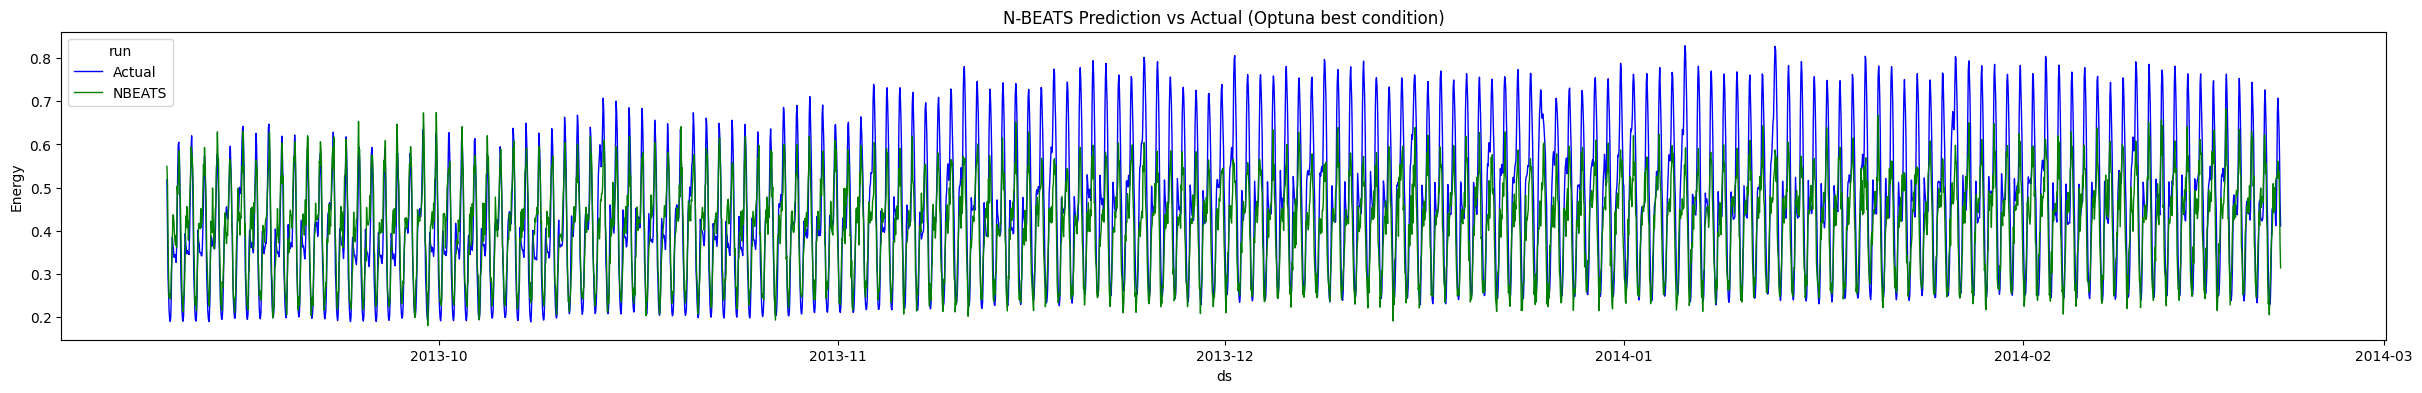

In [20]:
df_pred_melt = pd.melt(p, id_vars=['ds'], value_vars=['y', 'NBEATS'], var_name='run', value_name='Energy')
df_pred_melt.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATS Prediction vs Actual (Optuna best condition)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()


In [21]:
# combine prediction results with weather parameters
df_pred_combined = val[['ds','temperature']].merge(p, on = 'ds', how = 'left')
df_pred_combined

,ds,temperature,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,2013-09-09 21:00:00,10.33,1,0.549,0.0,0.0,2.0,0.518124
1,2013-09-09 22:00:00,10.33,1,0.509,0.0,0.0,2.0,0.404168
2,2013-09-09 23:00:00,10.33,1,0.385,0.0,0.0,2.0,0.294621
3,2013-09-10 00:00:00,10.33,1,0.290,0.0,0.0,1.0,0.251980
4,2013-09-10 01:00:00,10.36,1,0.246,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...,...
3935,2014-02-20 20:00:00,7.34,1,0.521,0.0,0.0,2.0,0.676087
3936,2014-02-20 21:00:00,6.84,1,0.538,0.0,0.0,2.0,0.638370
3937,2014-02-20 22:00:00,6.86,1,0.468,0.0,0.0,2.0,0.574031
3938,2014-02-20 23:00:00,6.34,1,0.369,0.0,0.0,2.0,0.470768


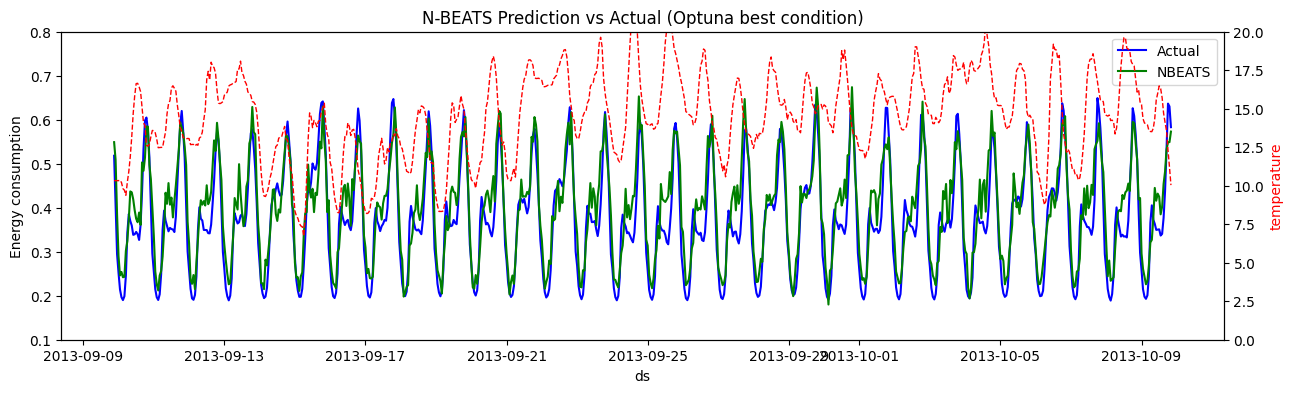

In [22]:
df_pred_sep = df_pred_combined[:720].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_sep, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_sep, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_sep, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

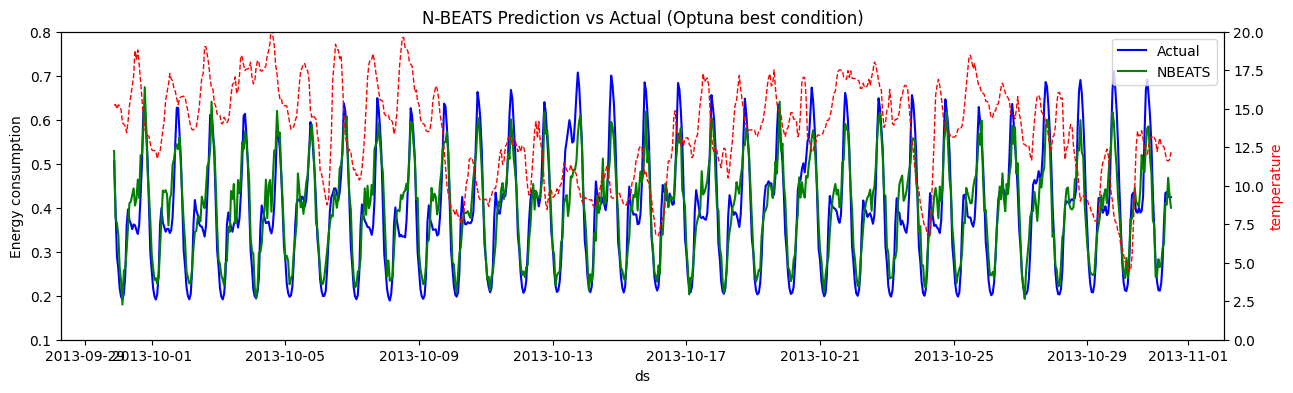

In [23]:
df_pred_oct = df_pred_combined[480:1240].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_oct, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_oct, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_oct, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

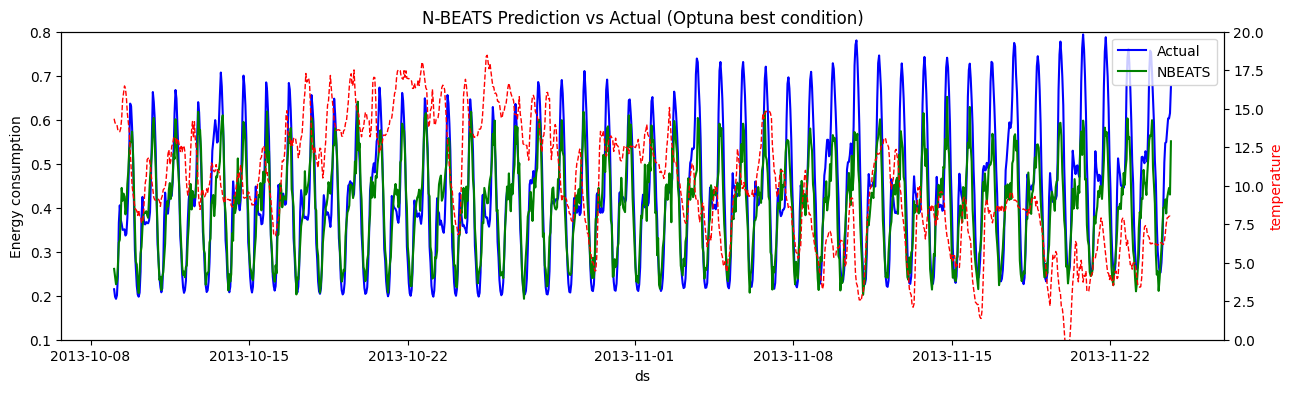

In [24]:
df_pred_nov = df_pred_combined[-3240:-2120].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

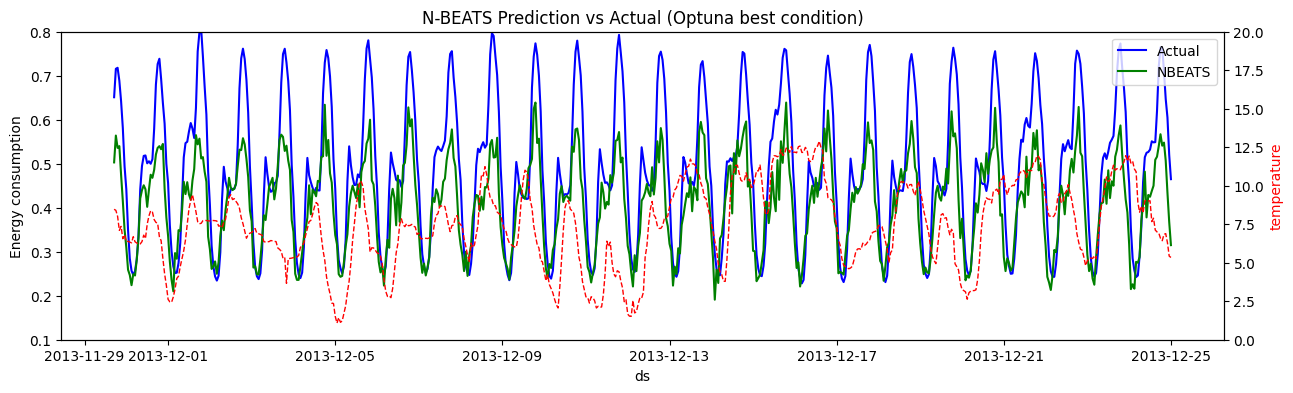

In [25]:
df_pred_dec = df_pred_combined[-2000:-1392].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_dec, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_dec, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_dec, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

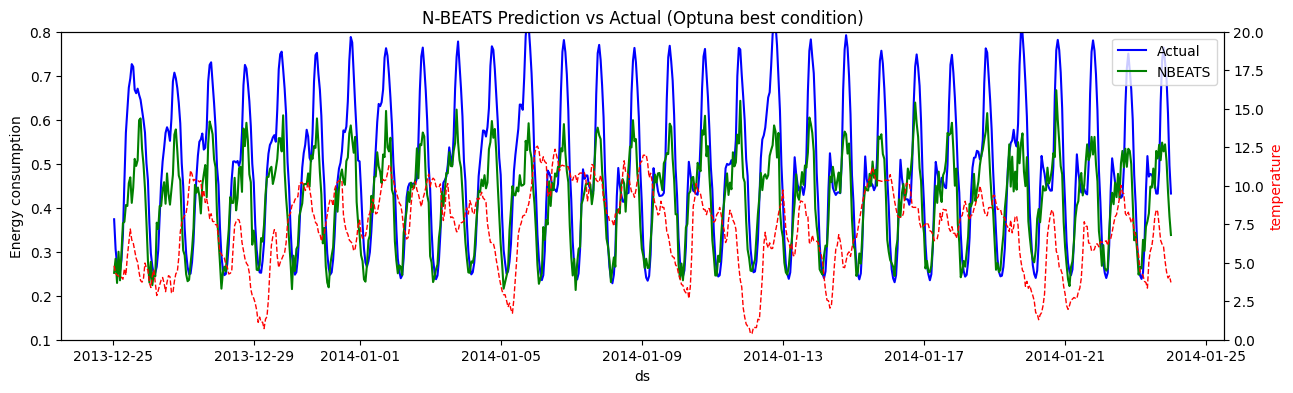

In [26]:
df_pred_jan = df_pred_combined[-1392:-672].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_jan, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_jan, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_jan, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

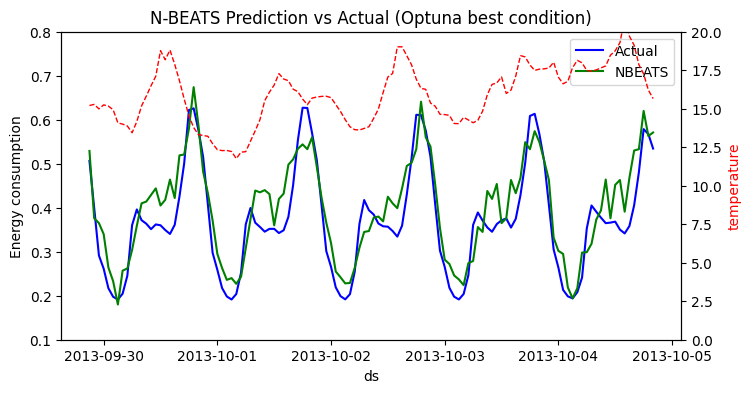

In [27]:
df_pred_zoom = df_pred_combined[480:600].copy()
plt.figure(figsize=(8,4))
ax = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

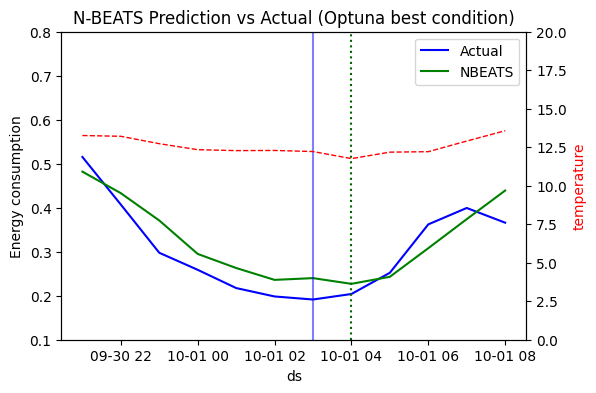

In [28]:
df_pred_trough = df_pred_combined[504:516].copy()

plt.figure(figsize=(6,4))
ax = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')

min_actual = df_pred_trough['y'].min()
min_NBEATS = df_pred_trough['NBEATS'].min()

ds_min_actual = df_pred_trough['ds'].loc[[df_pred_trough['y'].idxmin()]]
ds_min_NBEATS= df_pred_trough['ds'].loc[[df_pred_trough['NBEATS'].idxmin()]]

ax.axvline(ds_min_actual, color = 'b', linestyle='solid', alpha = 0.5)
ax2.axvline(ds_min_NBEATS, color = 'darkgreen', linestyle='dotted')

plt.show()

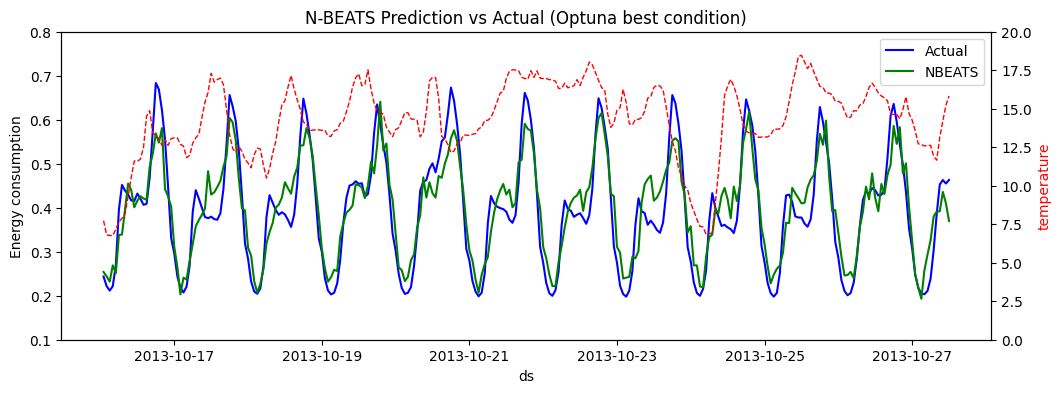

In [29]:
df_pred_zoom = df_pred_combined[-3072:-2796].copy()
plt.figure(figsize=(12,4))
ax = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

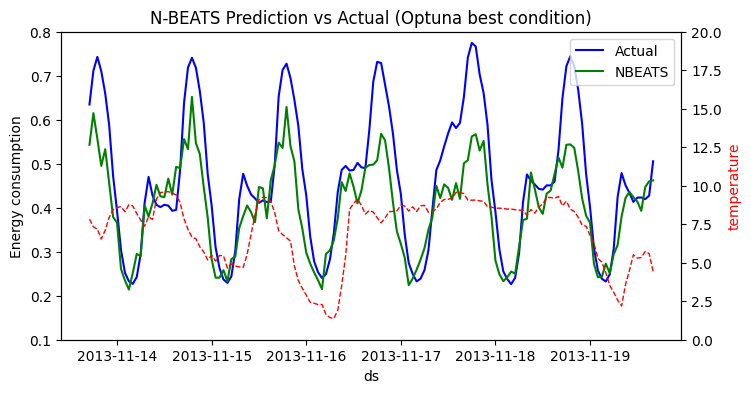

In [30]:
df_pred_zoom = df_pred_combined[-2384:-2240].copy()
plt.figure(figsize=(8,4))
ax = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_zoom, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

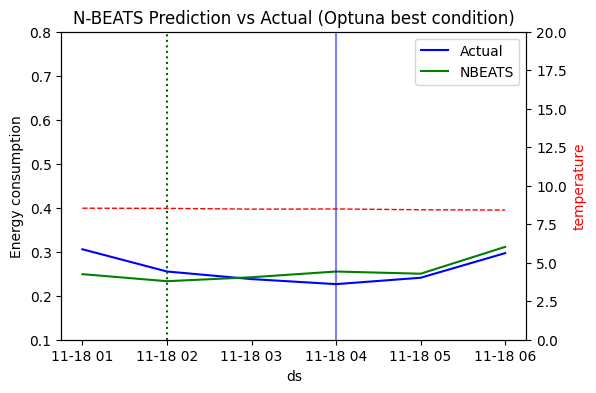

In [31]:
df_pred_trough = df_pred_combined[-2280:-2274].copy()
# df_pred_trough = df_pred_combined[648:660].copy()

plt.figure(figsize=(6,4))
ax = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_trough, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')

min_actual = df_pred_trough['y'].min()
min_NBEATS = df_pred_trough['NBEATS'].min()

ds_min_actual = df_pred_trough['ds'].loc[[df_pred_trough['y'].idxmin()]]
ds_min_NBEATS= df_pred_trough['ds'].loc[[df_pred_trough['NBEATS'].idxmin()]]

ax.axvline(ds_min_actual, color = 'b', linestyle='solid', alpha = 0.5)
ax2.axvline(ds_min_NBEATS, color = 'darkgreen', linestyle='dotted')

plt.show()

#### Check performance


In [32]:
input_size = 47

n_blocks_season = 1
n_blocks_trend = 1
n_blocks_identity = 3

mlp_units_n = 256
num_hidden = 2

n_harmonics = 1
n_polynomials = 3

scaler_type = 'standard'
learning_rate = 0.0007043606795427375


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATS(h=h,input_size=input_size,
              loss=DistributionLoss(distribution='Poisson', level=[90]),
              max_steps=100,
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
          ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p = model.predict(futr_df=val).reset_index()
p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss = mean_absolute_error(p['y'], p['NBEATS'])

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

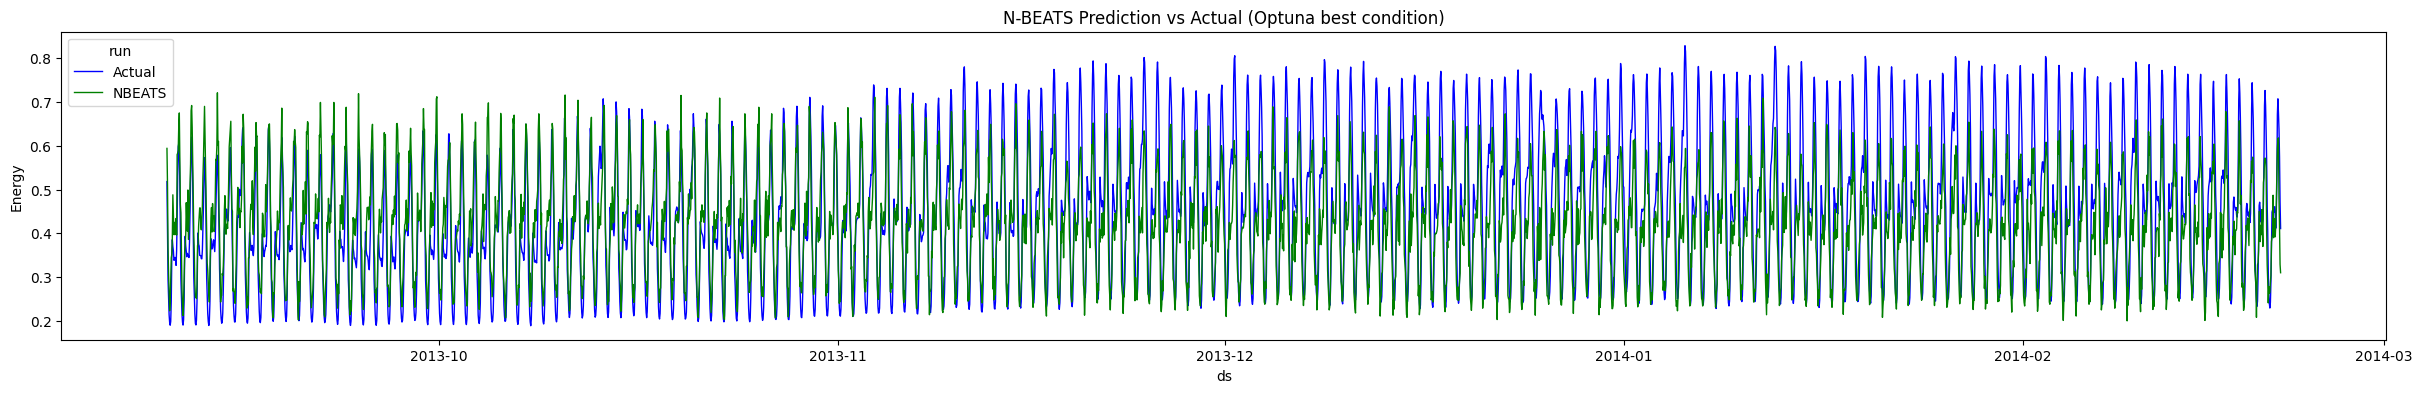

In [33]:
df_pred_melt = pd.melt(p, id_vars=['ds'], value_vars=['y', 'NBEATS'], var_name='run', value_name='Energy')
df_pred_melt.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATS Prediction vs Actual (Optuna best condition)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()

In [34]:
# combine prediction results with weather parameters
df_pred_combined = val[['ds','temperature']].merge(p, on = 'ds', how = 'left')
df_pred_combined

,ds,temperature,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,2013-09-09 21:00:00,10.33,1,0.594,0.0,0.0,2.0,0.518124
1,2013-09-09 22:00:00,10.33,1,0.511,0.0,0.0,2.0,0.404168
2,2013-09-09 23:00:00,10.33,1,0.368,0.0,0.0,2.0,0.294621
3,2013-09-10 00:00:00,10.33,1,0.308,0.0,0.0,1.0,0.251980
4,2013-09-10 01:00:00,10.36,1,0.267,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...,...
3935,2014-02-20 20:00:00,7.34,1,0.618,0.0,0.0,2.0,0.676087
3936,2014-02-20 21:00:00,6.84,1,0.481,0.0,0.0,2.0,0.638370
3937,2014-02-20 22:00:00,6.86,1,0.416,0.0,0.0,2.0,0.574031
3938,2014-02-20 23:00:00,6.34,1,0.329,0.0,0.0,1.0,0.470768


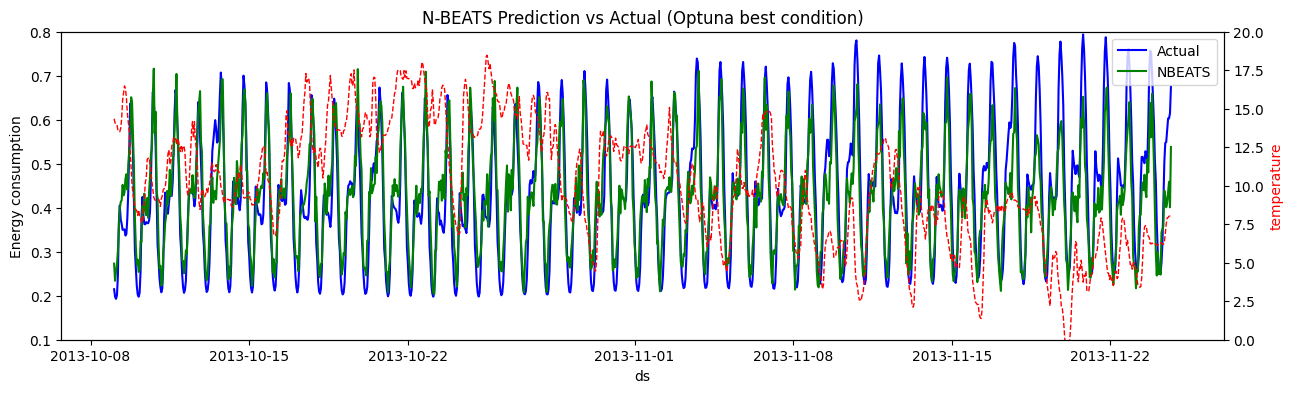

In [35]:
df_pred_nov = df_pred_combined[-3240:-2120].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

### Comment: Optuna tuning without or witout temperature as input parameter has not improved the model. The phenomenon observed at winter period remains.